# Module 07: Sampling & Generation - Interactive Notebook

This notebook provides a hands-on walkthrough of text generation and sampling strategies for transformer language models.

**Topics Covered:**
1. Greedy sampling (deterministic)
2. Temperature sampling (controlled randomness)
3. Top-k sampling (vocabulary filtering)
4. Top-p/nucleus sampling (dynamic filtering)
5. Combined sampling strategies
6. TextGenerator interface
7. Comparison and visualization
8. Interactive generation examples

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sys
from collections import Counter

# Add project root to path
sys.path.insert(0, str(Path.cwd().parent.parent.parent))

from tiny_transformer.sampling import (
    greedy_sample,
    temperature_sample,
    top_k_sample,
    top_p_sample,
    combined_sample,
    TextGenerator,
    GeneratorConfig
)
from tiny_transformer.model import TinyTransformerLM, get_model_config
from tiny_transformer.training import CharTokenizer, set_seed

set_seed(42)
print("✓ Imports successful")

✓ Imports successful


## 1. Understanding Sampling Basics

Language models output **logits** (unnormalized scores) for each token in the vocabulary. To generate text, we need to convert these logits into actual token selections.

Let's start with a simple example using mock logits.

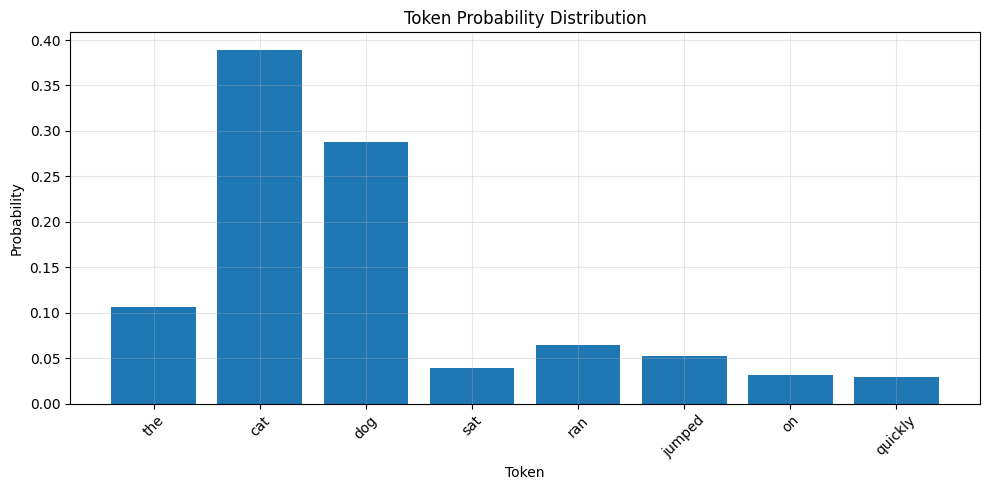

Token probabilities:
  the       : 0.1060
  cat       : 0.3890
  dog       : 0.2882
  sat       : 0.0390
  ran       : 0.0643
  jumped    : 0.0526
  on        : 0.0319
  quickly   : 0.0289


In [2]:
# Create simple example logits
# Higher logits = higher probability after softmax
vocab = ['the', 'cat', 'dog', 'sat', 'ran', 'jumped', 'on', 'quickly']
vocab_size = len(vocab)

# Example logits for next word prediction
logits = torch.tensor([[
    1.5,   # 'the'
    2.8,   # 'cat' - highest logit
    2.5,   # 'dog'
    0.5,   # 'sat'
    1.0,   # 'ran'
    0.8,   # 'jumped'
    0.3,   # 'on'
    0.2    # 'quickly'
]])

# Convert to probabilities
probs = F.softmax(logits, dim=-1)

# Visualize
plt.figure(figsize=(10, 5))
plt.bar(vocab, probs[0].numpy())
plt.xlabel('Token')
plt.ylabel('Probability')
plt.title('Token Probability Distribution')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Token probabilities:")
for token, prob in zip(vocab, probs[0]):
    print(f"  {token:10s}: {prob:.4f}")

## 2. Greedy Sampling

**Greedy sampling** always picks the token with the highest probability.

- **Pros:** Deterministic, reproducible
- **Cons:** Repetitive, lacks diversity

In [3]:
# Greedy sampling: argmax
greedy_token = greedy_sample(logits)
print(f"Greedy selection: {vocab[greedy_token.item()]}")
print(f"Selected probability: {probs[0, greedy_token].item():.4f}")

# Test determinism
print("\nDeterminism test (10 samples):")
samples = [greedy_sample(logits).item() for _ in range(10)]
print(f"All samples identical: {len(set(samples)) == 1}")
print(f"All samples: {[vocab[s] for s in samples]}")

Greedy selection: cat
Selected probability: 0.3890

Determinism test (10 samples):
All samples identical: True
All samples: ['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'cat']


## 3. Temperature Sampling

**Temperature** controls randomness by scaling logits before softmax:

$$\text{probs} = \text{softmax}(\text{logits} / T)$$

- **T → 0**: Becomes greedy (deterministic)
- **T = 1**: Original distribution
- **T > 1**: More random (flatter distribution)

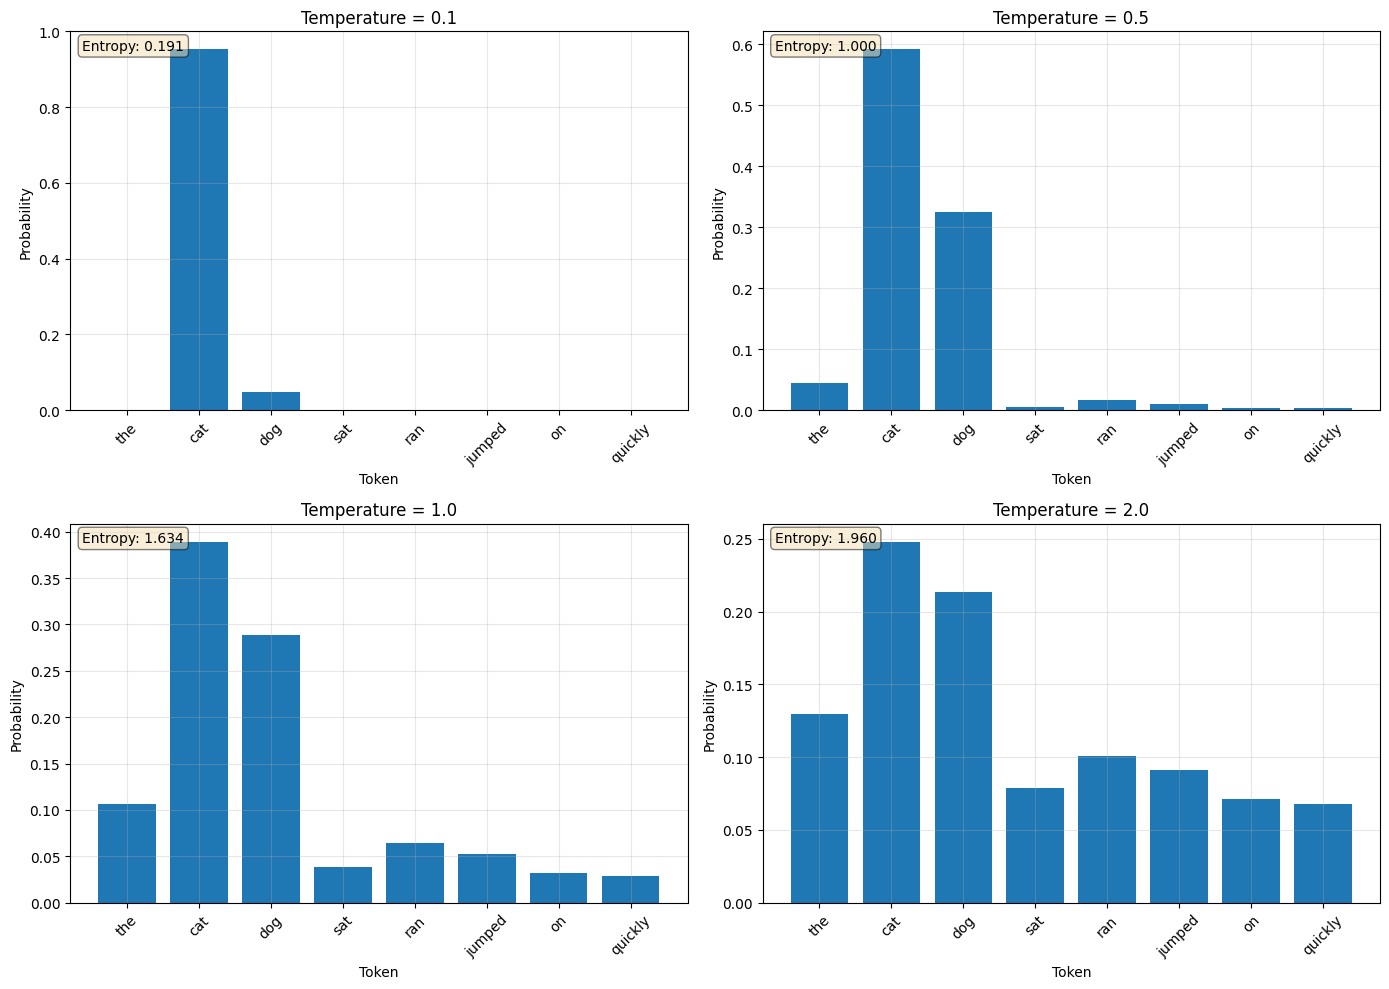

Observation: Lower temperature → more peaked distribution → less randomness
             Higher temperature → flatter distribution → more randomness


In [4]:
# Compare different temperatures
temperatures = [0.1, 0.5, 1.0, 2.0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, temp in enumerate(temperatures):
    # Compute temperature-scaled probabilities
    scaled_probs = F.softmax(logits / temp, dim=-1)
    
    axes[idx].bar(vocab, scaled_probs[0].numpy())
    axes[idx].set_xlabel('Token')
    axes[idx].set_ylabel('Probability')
    axes[idx].set_title(f'Temperature = {temp}')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3)
    
    # Calculate entropy (measure of randomness)
    entropy = -(scaled_probs * torch.log(scaled_probs + 1e-10)).sum().item()
    axes[idx].text(0.02, 0.98, f'Entropy: {entropy:.3f}', 
                   transform=axes[idx].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("Observation: Lower temperature → more peaked distribution → less randomness")
print("             Higher temperature → flatter distribution → more randomness")

In [5]:
# Sample with different temperatures
set_seed(42)

print("Temperature sampling (20 samples each):\n")
for temp in [0.1, 0.5, 1.0, 2.0]:
    samples = []
    for _ in range(20):
        token = temperature_sample(logits, temperature=temp)
        samples.append(vocab[token.item()])
    
    # Count frequencies
    freq = Counter(samples)
    
    print(f"T = {temp}:")
    print(f"  Unique tokens: {len(freq)}/{vocab_size}")
    print(f"  Most common: {freq.most_common(3)}")
    print()

Temperature sampling (20 samples each):

T = 0.1:
  Unique tokens: 1/8
  Most common: [('cat', 20)]

T = 0.5:
  Unique tokens: 5/8
  Most common: [('cat', 10), ('dog', 6), ('the', 2)]

T = 1.0:
  Unique tokens: 8/8
  Most common: [('cat', 9), ('dog', 4), ('sat', 2)]

T = 2.0:
  Unique tokens: 8/8
  Most common: [('cat', 5), ('jumped', 4), ('ran', 4)]



## 4. Top-K Sampling

**Top-k sampling** filters the vocabulary to the K tokens with highest probability, then samples from them.

- Prevents sampling from very low-probability tokens
- Fixed vocabulary size K
- Common values: K = 10, 50, 100

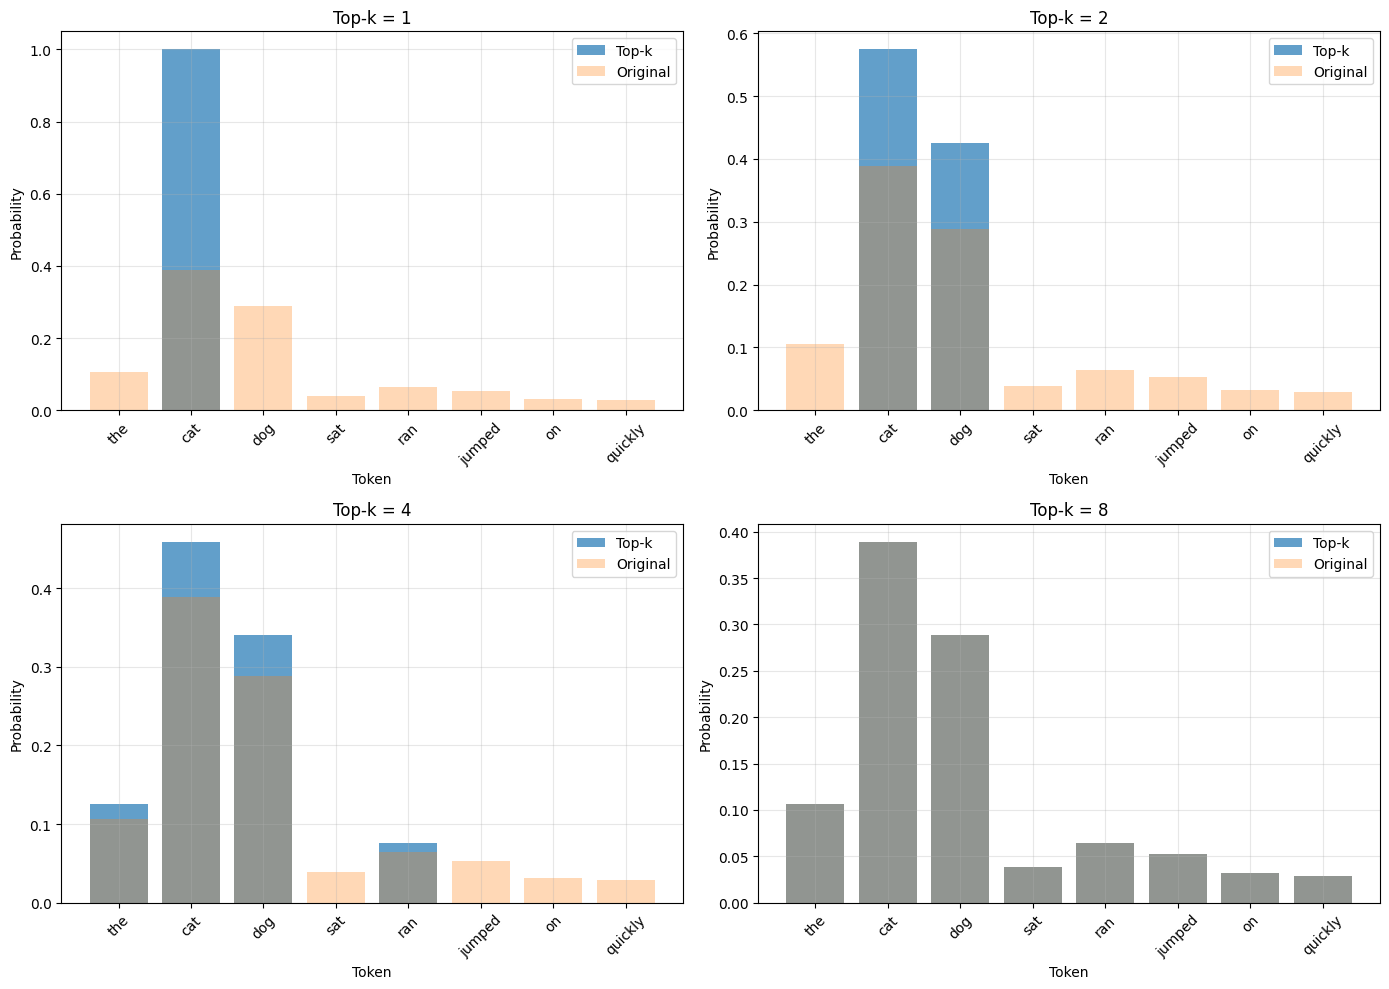

In [6]:
# Visualize top-k filtering
k_values = [1, 2, 4, 8]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

original_probs = F.softmax(logits, dim=-1)

for idx, k in enumerate(k_values):
    # Get top-k tokens
    topk_probs, topk_indices = torch.topk(original_probs, k, dim=-1)
    
    # Create filtered distribution (zeros for non-top-k)
    filtered_probs = torch.zeros_like(original_probs)
    filtered_probs.scatter_(1, topk_indices, topk_probs)
    
    # Renormalize
    filtered_probs = filtered_probs / filtered_probs.sum(dim=-1, keepdim=True)
    
    axes[idx].bar(vocab, filtered_probs[0].numpy(), alpha=0.7, label='Top-k')
    axes[idx].bar(vocab, original_probs[0].numpy(), alpha=0.3, label='Original')
    axes[idx].set_xlabel('Token')
    axes[idx].set_ylabel('Probability')
    axes[idx].set_title(f'Top-k = {k}')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Sample with different k values
set_seed(42)

print("Top-k sampling (20 samples each):\n")
for k in [1, 2, 4, 8]:
    samples = []
    for _ in range(20):
        token = top_k_sample(logits, k=k, temperature=1.0)
        samples.append(vocab[token.item()])
    
    freq = Counter(samples)
    
    print(f"k = {k}:")
    print(f"  Unique tokens: {len(freq)}/{vocab_size}")
    print(f"  Most common: {freq.most_common(3)}")
    print()

Top-k sampling (20 samples each):

k = 1:
  Unique tokens: 1/8
  Most common: [('cat', 20)]

k = 2:
  Unique tokens: 2/8
  Most common: [('cat', 12), ('dog', 8)]

k = 4:
  Unique tokens: 4/8
  Most common: [('cat', 11), ('dog', 6), ('the', 2)]

k = 8:
  Unique tokens: 6/8
  Most common: [('dog', 6), ('cat', 5), ('jumped', 3)]



## 5. Top-P (Nucleus) Sampling

**Top-p sampling** (nucleus sampling) selects the smallest set of tokens whose cumulative probability exceeds p.

- Dynamic vocabulary size (adapts to distribution)
- More principled than top-k
- Common values: p = 0.9, 0.95

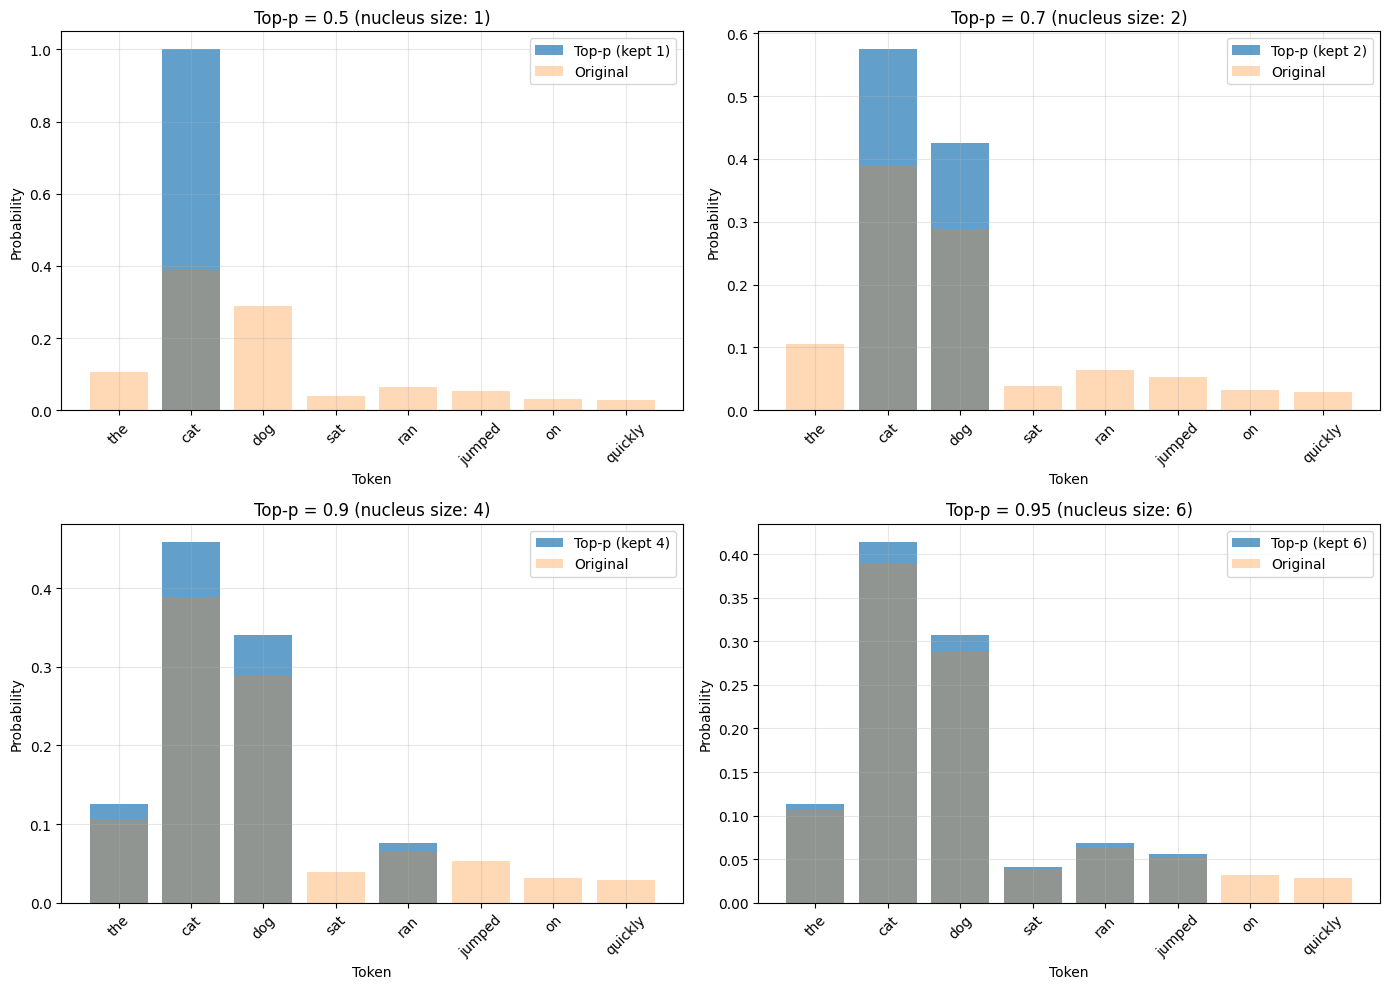

Observation: Top-p adapts to the distribution shape
            Peaked distributions → fewer tokens
            Flat distributions → more tokens


In [8]:
# Visualize top-p filtering
p_values = [0.5, 0.7, 0.9, 0.95]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

original_probs = F.softmax(logits, dim=-1)

for idx, p in enumerate(p_values):
    # Sort probabilities
    sorted_probs, sorted_indices = torch.sort(original_probs, descending=True, dim=-1)
    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
    
    # Find cutoff
    cutoff_mask = cumulative_probs <= p
    # Include at least one token
    cutoff_mask[..., 0] = True
    
    # Filter
    filtered_probs = torch.zeros_like(original_probs)
    filtered_probs.scatter_(1, sorted_indices, sorted_probs * cutoff_mask.float())
    
    # Renormalize
    filtered_probs = filtered_probs / (filtered_probs.sum(dim=-1, keepdim=True) + 1e-10)
    
    num_kept = cutoff_mask.sum().item()
    
    axes[idx].bar(vocab, filtered_probs[0].numpy(), alpha=0.7, label=f'Top-p (kept {num_kept})')
    axes[idx].bar(vocab, original_probs[0].numpy(), alpha=0.3, label='Original')
    axes[idx].set_xlabel('Token')
    axes[idx].set_ylabel('Probability')
    axes[idx].set_title(f'Top-p = {p} (nucleus size: {num_kept})')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation: Top-p adapts to the distribution shape")
print("            Peaked distributions → fewer tokens")
print("            Flat distributions → more tokens")

In [9]:
# Sample with different p values
set_seed(42)

print("Top-p sampling (20 samples each):\n")
for p in [0.5, 0.7, 0.9, 0.95]:
    samples = []
    for _ in range(20):
        token = top_p_sample(logits, p=p, temperature=1.0)
        samples.append(vocab[token.item()])
    
    freq = Counter(samples)
    
    print(f"p = {p}:")
    print(f"  Unique tokens: {len(freq)}/{vocab_size}")
    print(f"  Most common: {freq.most_common(3)}")
    print()

Top-p sampling (20 samples each):

p = 0.5:
  Unique tokens: 1/8
  Most common: [('cat', 20)]

p = 0.7:
  Unique tokens: 2/8
  Most common: [('cat', 12), ('dog', 8)]

p = 0.9:
  Unique tokens: 4/8
  Most common: [('cat', 11), ('dog', 6), ('the', 2)]

p = 0.95:
  Unique tokens: 5/8
  Most common: [('dog', 6), ('cat', 5), ('ran', 4)]



## 6. Combined Sampling

**Combined sampling** applies multiple filters in sequence:
1. Temperature scaling
2. Top-k filtering
3. Top-p filtering

This is the most common approach in production systems (e.g., GPT, Claude).

In [10]:
# Compare different sampling configurations
configs = [
    {"name": "Greedy", "temp": 0.0, "top_k": None, "top_p": None},
    {"name": "Low temp", "temp": 0.5, "top_k": None, "top_p": None},
    {"name": "Temp + Top-k", "temp": 0.8, "top_k": 4, "top_p": None},
    {"name": "Temp + Top-p", "temp": 0.8, "top_k": None, "top_p": 0.9},
    {"name": "All combined", "temp": 0.8, "top_k": 6, "top_p": 0.95},
]

set_seed(42)

print("Sampling strategy comparison (30 samples each):\n")
for config in configs:
    samples = []
    for _ in range(30):
        if config["temp"] == 0.0:
            token = greedy_sample(logits)
        else:
            token = combined_sample(
                logits, 
                temperature=config["temp"],
                top_k=config["top_k"],
                top_p=config["top_p"]
            )
        samples.append(vocab[token.item()])
    
    freq = Counter(samples)
    
    print(f"{config['name']}:")
    print(f"  Config: temp={config['temp']}, top_k={config['top_k']}, top_p={config['top_p']}")
    print(f"  Unique tokens: {len(freq)}/{vocab_size}")
    print(f"  Distribution: {freq.most_common()}")
    print()

Sampling strategy comparison (30 samples each):

Greedy:
  Config: temp=0.0, top_k=None, top_p=None
  Unique tokens: 1/8
  Distribution: [('cat', 30)]

Low temp:
  Config: temp=0.5, top_k=None, top_p=None
  Unique tokens: 4/8
  Distribution: [('cat', 22), ('dog', 5), ('ran', 2), ('sat', 1)]

Temp + Top-k:
  Config: temp=0.8, top_k=4, top_p=None
  Unique tokens: 4/8
  Distribution: [('cat', 17), ('dog', 8), ('the', 4), ('ran', 1)]

Temp + Top-p:
  Config: temp=0.8, top_k=None, top_p=0.9
  Unique tokens: 4/8
  Distribution: [('cat', 14), ('dog', 11), ('ran', 3), ('the', 2)]

All combined:
  Config: temp=0.8, top_k=6, top_p=0.95
  Unique tokens: 4/8
  Distribution: [('cat', 17), ('dog', 10), ('the', 2), ('ran', 1)]



## 7. TextGenerator - High-Level Interface

The `TextGenerator` class provides a convenient interface for autoregressive text generation.

In [11]:
# Create a tiny model for generation demos
text = "hello world this is a test of the text generation system. " * 10

# Create tokenizer
tokenizer = CharTokenizer()
tokenizer.fit(text)

print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Characters: {sorted(tokenizer.vocab.keys())}")

Vocabulary size: 19
Characters: [' ', '.', 'a', 'd', 'e', 'f', 'g', 'h', 'i', 'l', 'm', 'n', 'o', 'r', 's', 't', 'w', 'x', 'y']


In [12]:
# Create and train a tiny model (just for demo purposes)
# In practice, you'd load a pre-trained checkpoint

from tiny_transformer.training import TextDataset, Trainer, TrainerConfig
from torch.utils.data import DataLoader

# Create tiny model
config = get_model_config('tiny')
model = TinyTransformerLM(
    vocab_size=tokenizer.vocab_size,
    **config
)

# Quick training (just to get sensible outputs)
tokens = tokenizer.encode(text)
dataset = TextDataset(tokens, seq_len=32)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

trainer_config = TrainerConfig(
    learning_rate=1e-3,
    max_steps=200,  # Must be > warmup_steps (default is 100)
    log_interval=20,
    device='cpu'
)

trainer = Trainer(model, train_loader, config=trainer_config)
print("Training for 200 steps...")
trainer.train()
print("\n✓ Training complete")

Training for 200 steps...
Starting Training
Device: cpu
Training samples: 18
Config: TrainerConfig(learning_rate=0.001, weight_decay=0.01, betas=(0.9, 0.95), grad_clip=1.0, log_interval=20, eval_interval=500, save_interval=1000, max_steps=200, num_epochs=10, warmup_steps=100, device='cpu', checkpoint_dir='checkpoints', pad_token_id=None)

Epoch 3 | Step 20 | Loss: 2.6292 | PPL: 13.86 | LR: 2.00e-04 | Grad: 1.76


Epoch 7 | Step 40 | Loss: 2.5520 | PPL: 12.83 | LR: 4.00e-04 | Grad: 1.18
Epoch 11 | Step 60 | Loss: 1.9043 | PPL: 6.71 | LR: 6.00e-04 | Grad: 1.48


Epoch 15 | Step 80 | Loss: 1.5319 | PPL: 4.63 | LR: 8.00e-04 | Grad: 1.48
Epoch 19 | Step 100 | Loss: 1.2641 | PPL: 3.54 | LR: 1.00e-03 | Grad: 1.26


Epoch 23 | Step 120 | Loss: 1.1016 | PPL: 3.01 | LR: 9.14e-04 | Grad: 1.63
Epoch 27 | Step 140 | Loss: 0.9718 | PPL: 2.64 | LR: 6.89e-04 | Grad: 1.91


Epoch 31 | Step 160 | Loss: 0.8373 | PPL: 2.31 | LR: 4.11e-04 | Grad: 2.17
Epoch 35 | Step 180 | Loss: 0.7032 | PPL: 2.02 | LR: 1.86e-04 | Grad: 1.44


Epoch 39 | Step 200 | Loss: 0.6456 | PPL: 1.91 | LR: 1.00e-04 | Grad: 1.35
Reached max_steps (200). Stopping training.

Training Complete! Time: 1s

✓ Training complete


In [13]:
# Use TextGenerator with different configurations
model.eval()

# Starting prompt
prompt = "hello "
prompt_tokens = torch.tensor([tokenizer.encode(prompt)])

print(f"Prompt: '{prompt}'\n")
print("="*70)

# Try different sampling strategies
strategies = [
    {"name": "Greedy", "config": GeneratorConfig(max_new_tokens=30, do_sample=False)},
    {"name": "Temperature=0.5", "config": GeneratorConfig(max_new_tokens=30, temperature=0.5)},
    {"name": "Temperature=1.0", "config": GeneratorConfig(max_new_tokens=30, temperature=1.0)},
    {"name": "Top-k=5", "config": GeneratorConfig(max_new_tokens=30, temperature=0.8, top_k=5)},
    {"name": "Top-p=0.9", "config": GeneratorConfig(max_new_tokens=30, temperature=0.8, top_p=0.9)},
    {"name": "Combined", "config": GeneratorConfig(max_new_tokens=30, temperature=0.8, top_k=10, top_p=0.95)},
]

for strategy in strategies:
    generator = TextGenerator(model, strategy["config"], device='cpu')
    
    with torch.no_grad():
        output_tokens = generator.generate(prompt_tokens)
    
    output_text = tokenizer.decode(output_tokens[0].tolist())
    
    print(f"\n{strategy['name']}:")
    print(f"  {output_text}")

print("\n" + "="*70)

Prompt: 'hello '


Greedy:
  hello system. helo wo world world th

Temperature=0.5:
  hello this testestest thest oratext 

Temperature=1.0:
  hello s wo tet gesystesod gelof t ti

Top-k=5:
  hello is wo this hest test of te te 

Top-p=0.9:
  hello this is te test te t of te t t

Combined:
  hello sthestest testested t tem. gex



## 8. Diversity vs Quality Trade-off

Different sampling strategies offer different trade-offs between:
- **Quality**: Coherence, grammaticality
- **Diversity**: Variety, creativity

Let's measure diversity quantitatively.

In [14]:
def measure_diversity(model, generator_config, prompt_tokens, tokenizer, num_samples=10):
    """Measure diversity of generated samples."""
    generator = TextGenerator(model, generator_config, device='cpu')
    
    texts = []
    with torch.no_grad():
        for _ in range(num_samples):
            output_tokens = generator.generate(prompt_tokens)
            text = tokenizer.decode(output_tokens[0].tolist())
            texts.append(text)
    
    # Calculate metrics
    unique_texts = len(set(texts))
    avg_length = np.mean([len(t) for t in texts])
    
    # Character-level diversity
    all_chars = ''.join(texts)
    unique_chars = len(set(all_chars))
    
    return {
        'unique_samples': unique_texts,
        'total_samples': num_samples,
        'uniqueness_ratio': unique_texts / num_samples,
        'avg_length': avg_length,
        'unique_chars': unique_chars,
        'samples': texts[:3]  # First 3 for inspection
    }

# Compare diversity
configs_to_test = [
    ("Greedy", GeneratorConfig(max_new_tokens=20, do_sample=False)),
    ("Temp=0.3", GeneratorConfig(max_new_tokens=20, temperature=0.3)),
    ("Temp=0.8", GeneratorConfig(max_new_tokens=20, temperature=0.8)),
    ("Temp=1.5", GeneratorConfig(max_new_tokens=20, temperature=1.5)),
    ("Top-p=0.9", GeneratorConfig(max_new_tokens=20, temperature=0.8, top_p=0.9)),
]

results = []
for name, config in configs_to_test:
    print(f"Testing {name}...")
    metrics = measure_diversity(model, config, prompt_tokens, tokenizer, num_samples=10)
    results.append((name, metrics))

# Display results
print("\n" + "="*70)
print("DIVERSITY ANALYSIS")
print("="*70 + "\n")

for name, metrics in results:
    print(f"{name}:")
    print(f"  Unique samples: {metrics['unique_samples']}/{metrics['total_samples']}")
    print(f"  Uniqueness ratio: {metrics['uniqueness_ratio']:.2%}")
    print(f"  Unique characters: {metrics['unique_chars']}")
    print(f"  Sample outputs:")
    for i, sample in enumerate(metrics['samples'], 1):
        print(f"    {i}. {sample[:50]}...")
    print()

Testing Greedy...


Testing Temp=0.3...


Testing Temp=0.8...


Testing Temp=1.5...


Testing Top-p=0.9...



DIVERSITY ANALYSIS

Greedy:
  Unique samples: 1/10
  Uniqueness ratio: 10.00%
  Unique characters: 12
  Sample outputs:
    1. hello system. helo wo worl...
    2. hello system. helo wo worl...
    3. hello system. helo wo worl...

Temp=0.3:
  Unique samples: 10/10
  Uniqueness ratio: 100.00%
  Unique characters: 16
  Sample outputs:
    1. hello sthestestestest of t...
    2. hello systelo thestesteste...
    3. hello systewo ted testeste...

Temp=0.8:
  Unique samples: 10/10
  Uniqueness ratio: 100.00%
  Unique characters: 17
  Sample outputs:
    1. hello systis hestestestewo...
    2. hello ysthem. helo his hes...
    3. hello wo wold ys testestes...

Temp=1.5:
  Unique samples: 10/10
  Uniqueness ratio: 100.00%
  Unique characters: 18
  Sample outputs:
    1. hello s s is ge a ohxthi h...
    2. hello m. i m. mywf lold. m...
    3. hello w.tis s wox wora tes...

Top-p=0.9:
  Unique samples: 10/10
  Uniqueness ratio: 100.00%
  Unique characters: 16
  Sample outputs:
    1. hello w

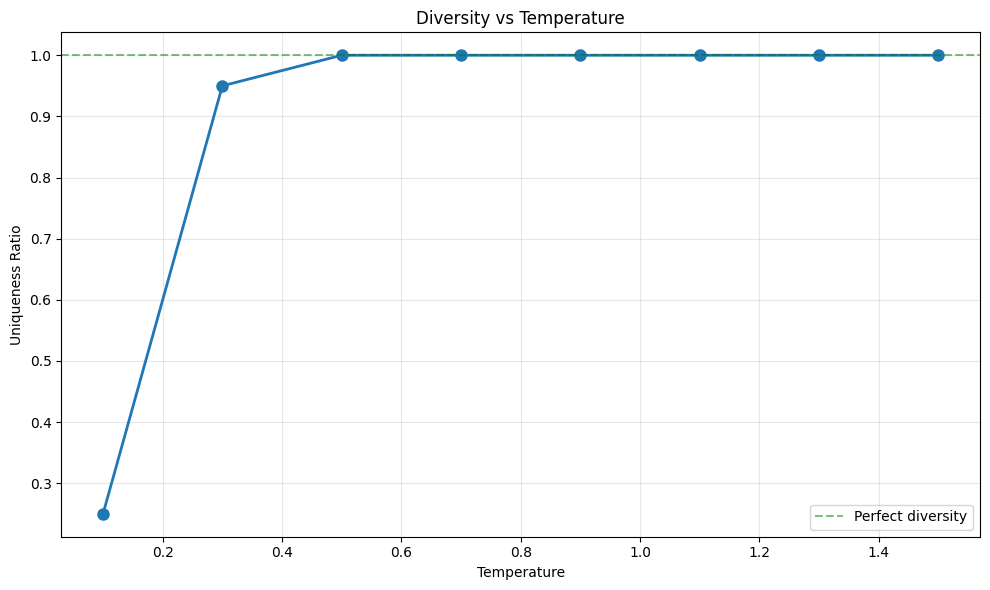

Observation: Higher temperature → more diversity (but possibly less coherence)


In [15]:
# Visualize diversity vs temperature
temperatures = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
diversity_scores = []

for temp in temperatures:
    config = GeneratorConfig(max_new_tokens=20, temperature=temp)
    metrics = measure_diversity(model, config, prompt_tokens, tokenizer, num_samples=20)
    diversity_scores.append(metrics['uniqueness_ratio'])

plt.figure(figsize=(10, 6))
plt.plot(temperatures, diversity_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel('Temperature')
plt.ylabel('Uniqueness Ratio')
plt.title('Diversity vs Temperature')
plt.grid(True, alpha=0.3)
plt.axhline(y=1.0, color='g', linestyle='--', alpha=0.5, label='Perfect diversity')
plt.legend()
plt.tight_layout()
plt.show()

print("Observation: Higher temperature → more diversity (but possibly less coherence)")

## 9. EOS Token Handling

TextGenerator can stop generation early when an end-of-sequence (EOS) token is generated.

In [16]:
# Demonstrate EOS handling
# Let's use newline as EOS
eos_token_id = tokenizer.vocab.get('\n', None)

if eos_token_id is not None:
    print(f"Using newline as EOS token (id={eos_token_id})\n")
    
    # Generate with EOS handling
    config = GeneratorConfig(
        max_new_tokens=50,
        temperature=0.8,
        eos_token_id=eos_token_id
    )
    
    generator = TextGenerator(model, config, device='cpu')
    
    with torch.no_grad():
        output_tokens = generator.generate(prompt_tokens)
    
    output_text = tokenizer.decode(output_tokens[0].tolist())
    
    print(f"Generated text (stops at newline):")
    print(f"  {output_text}")
    print(f"\nGenerated {len(output_tokens[0])} tokens (max was {len(prompt_tokens[0]) + 50})")
else:
    print("No newline in vocabulary, skipping EOS demo")

No newline in vocabulary, skipping EOS demo


## 10. Batch Generation

TextGenerator supports generating multiple sequences in parallel.

In [17]:
# Create multiple prompts
prompts = [
    "hello ",
    "this is ",
    "test "
]

# Encode prompts and pad to same length
from torch.nn.utils.rnn import pad_sequence

prompt_tokens_list = [torch.tensor(tokenizer.encode(p)) for p in prompts]
prompt_tokens_batch = pad_sequence(prompt_tokens_list, batch_first=True, padding_value=0)

print(f"Batch shape: {prompt_tokens_batch.shape}")
print(f"Individual lengths: {[len(p) for p in prompt_tokens_list]}\n")

# Generate for all prompts at once
config = GeneratorConfig(
    max_new_tokens=20,
    temperature=0.8,
    top_p=0.9
)

generator = TextGenerator(model, config, device='cpu')

with torch.no_grad():
    output_tokens_batch = generator.generate(prompt_tokens_batch)

print("Batch generation results:\n")
for i, (prompt, output_tokens) in enumerate(zip(prompts, output_tokens_batch)):
    output_text = tokenizer.decode(output_tokens.tolist())
    print(f"{i+1}. Prompt: '{prompt}'")
    print(f"   Output: '{output_text}'\n")

Batch shape: torch.Size([3, 8])
Individual lengths: [6, 8, 5]

Batch generation results:

1. Prompt: 'hello '
   Output: 'hello   wo is testest test o'

2. Prompt: 'this is '
   Output: 'this is a of t t of t te t t'

3. Prompt: 'test '
   Output: 'test    t t t t t   t t  t t'



## Summary

In this notebook, we explored:

1. **Greedy Sampling** - Deterministic, always picks highest probability token
2. **Temperature Sampling** - Controls randomness by scaling logits
3. **Top-K Sampling** - Filters to K highest probability tokens
4. **Top-P (Nucleus) Sampling** - Dynamically filters by cumulative probability
5. **Combined Sampling** - Uses temperature + top-k + top-p together
6. **TextGenerator** - High-level interface for text generation
7. **Diversity Analysis** - Trade-offs between quality and diversity
8. **EOS Handling** - Early stopping with end-of-sequence tokens
9. **Batch Generation** - Efficient parallel generation

### Key Takeaways:

- **Greedy** is fast but repetitive
- **Temperature** controls randomness (lower = more deterministic)
- **Top-k** prevents low-probability tokens (fixed size)
- **Top-p** adapts to distribution shape (variable size)
- **Combined** (temp + top-k/top-p) is most common in production
- Higher diversity often means lower coherence

### Recommended Settings:

- **Factual text**: temperature=0.3-0.5, top-p=0.9
- **Creative writing**: temperature=0.8-1.0, top-p=0.95
- **Code generation**: temperature=0.2-0.4, top-p=0.9

### Next Steps:

- Try the exercises in `exercises/exercises.py`
- Experiment with different sampling strategies
- Train on larger datasets (Shakespeare, WikiText)
- Move on to Module 08 (Engineering Practices)